In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import ttest_ind, ks_2samp

# Display all columns
pd.set_option('display.max_columns', None)

In [2]:
# Load the stage 4 property data
df = pd.read_csv(r'Output Files\stage_4_property_data.csv') 
df.head(3)

,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Area,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Power Back Up,Lift,Rain Water Harvesting,Club House,Swimming Pool,Gymnasium,Park,Parking,Security,Water Storage,Private Terrace/Garden,Vaastu Compliant,Service/Goods Lift,Air Conditioned,Visitor Parking,Intercom Facility,Maintenance Staff,Waste Disposal,Laundry Service,Internet/Wi-Fi Connectivity,DTH Television Facility,RO Water System,Banquet Hall,Bar/Lounge,Cafeteria/Food Court,Conference Room,Piped Gas,Jogging and Strolling Track,Outdoor Tennis Courts,Mansion,Downtown,Skyline View,Wrap Around Balcony,Island Kitchen Layout,Full Glass Wall,House help accommodation,Concierge Services,Garden View,Marble flooring,Well Furnished,Modular Kitchen,Helipad,Private pool,Private Jaccuzi,Mini Cinema Theatre,Golf Course,Infinity Swimming Pool,Pool with temperature control,Sea facing,Skydeck,Earth quake resistant,Theme based Architectures,Health club with Steam / Jaccuzi,Large Clubhouse,Large Open space,Fingerprint Access,Grand Entrance lobby,Private Garage,Fireplace,Wine Cellar,Sky Villa,Water Front,Hilltop,Smart Home,Barbeque space,Kids play area,Library,Puja Room,Study,Servant Room,Store,Aerobics Room,Canopy Walk,Coffee Lounge & Restaurants,Dance Studio,Event Space & Amphitheatre,Flower Gardens,Guest Accommodation,Indoor Squash & Badminton Courts,Kids Play Area,Kids Play Pool With Water Slides,Library And Business Centre,Meditation Area,Multipurpose Courts,Recreational Pool,Rentable CommuniPfty Space,Retail Boulevard (Retail Shops),Cycling & Jogging Track,Fire Fighting Equipment,Aesthetically designed landscape garden,latitude,longitude,geocoded_address,Area_Broader,Price_bin
0,Ready to Move,Immediately,20.0,Y,Tata Housing Development Company Ltd.,0.63,Rajoli naka,763.571943,Tata Amantra,8250.696031,579.0,Kalyan West,Sq-ft,Unfurnished,2.0,East,New Property,Apartment,Thane,2,Agent,34.0,Y,Sq-ft,New construction,2.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.240353,73.125279,"Kalyan West, Kalyan-Dombivli, Kalyan Taluka, T...",Kalyan West,Low
1,Ready to Move,Immediately,18.0,N,Sai Satyam Developers,0.54,This property has reputed scholl ints vicinity.,850.000000,Sai Satyam Homes,6352.000000,585.0,Kalyan West,Sq-ft,Unfurnished,2.0,East,New Property,Apartment,Thane,2,Agent,18.0,Y,Sq-ft,New construction,2.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.240353,73.125279,"Kalyan West, Kalyan-Dombivli, Kalyan Taluka, T...",Kalyan West,Low
2,Under Construction,Dec 25,5.0,N,Birla Estates,0.90,Shahad is one of the attractive locations to o...,1050.000000,Birla Vanya,8571.000000,815.0,Kalyan West,Sq-ft,Unfurnished,2.0,East,New Property,Apartment,Thane,2,Agent,27.0,Y,Sq-ft,Less than 5 years,3.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.240353,73.125279,"Kalyan West, Kalyan-Dombivli, Kalyan Taluka, T...",Kalyan West,Medium


In [3]:
# Check shape
df.shape

(6290, 121)

# <b>Feature engineering</b>

#### Utilities

In [4]:
# Function to plot Distribution plot and Box plot for a dataframe column
def plot_distribution_and_boxplot(df: pd.DataFrame, column: str):
    """
    Plot histogram with KDE and boxplot for a given column in a DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame
        column (str): Column name to plot
    """
    sns.set_style('whitegrid')
    palette = sns.color_palette('pastel')

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Distribution plot on the left
    sns.histplot(df[column].dropna(), kde=True, color=palette[0], ax=axes[0], edgecolor='black', linewidth=0.7)

    axes[0].set_title(f'Distribution of {column}', fontsize=16, fontweight='bold')
    axes[0].set_xlabel(column, fontsize=14)
    axes[0].set_ylabel('Density', fontsize=14)

    # Box plot on the right
    sns.boxplot(x=df[column], color=palette[1], ax=axes[1], fliersize=5, linewidth=1.2)
    axes[1].set_title(f'Boxplot of {column}', fontsize=16, fontweight='bold')
    axes[1].set_xlabel(column, fontsize=14)
    axes[1].set_yticks([])  # Hide y-axis ticks for boxplot

    plt.tight_layout()
    plt.show()

-----------------

Rename features:

In [5]:
# Rename 'Area' and 'Area_Broader'
df.rename(columns={'Area': 'Locality', 'Area_Broader': 'Area'}, inplace=True)

# Rename Servant Room and Store
df.rename(columns={'Servant Room': 'House Help Room', 'Store': 'Store Room'}, inplace=True)

Remove Property listings with very less frequent occuring area in dataset:

In [6]:
# Filter out less occuring areas
less_occuring_areas = df['Area'].value_counts()[df['Area'].value_counts() < 3].index

# Remove property listings with less occuring areas
df = df[~(df['Area'].isin(less_occuring_areas))]

In [7]:
# Check updated shape
df.shape

(6281, 121)

In [8]:
# Info
pd.set_option('display.max_info_columns', 200)
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 6281 entries, 0 to 6289
Data columns (total 121 columns):
 #    Column                                   Non-Null Count  Dtype  
---   ------                                   --------------  -----  
 0    Possession Status                        6281 non-null   object 
 1    Availability Starts From                 6281 non-null   object 
 2    Floor No                                 6281 non-null   float64
 3    Commercial                               6281 non-null   object 
 4    Developer                                6281 non-null   object 
 5    Price (Crores)                           6281 non-null   float64
 6    Landmark                                 6281 non-null   object 
 7    Covered Area                             6281 non-null   float64
 8    Society                                  6281 non-null   object 
 9    sqft Price (INR)                         6281 non-null   float64
 10   Carpet Area                            

----------

Construct a new Feature 'Floor Level' depending upon Floor No:

-----------Statistics of Floor No------------
count    6281.000000
mean       10.790957
std         9.411273
min        -2.000000
25%         4.000000
50%         8.000000
75%        15.000000
max        93.000000
Name: Floor No, dtype: float64



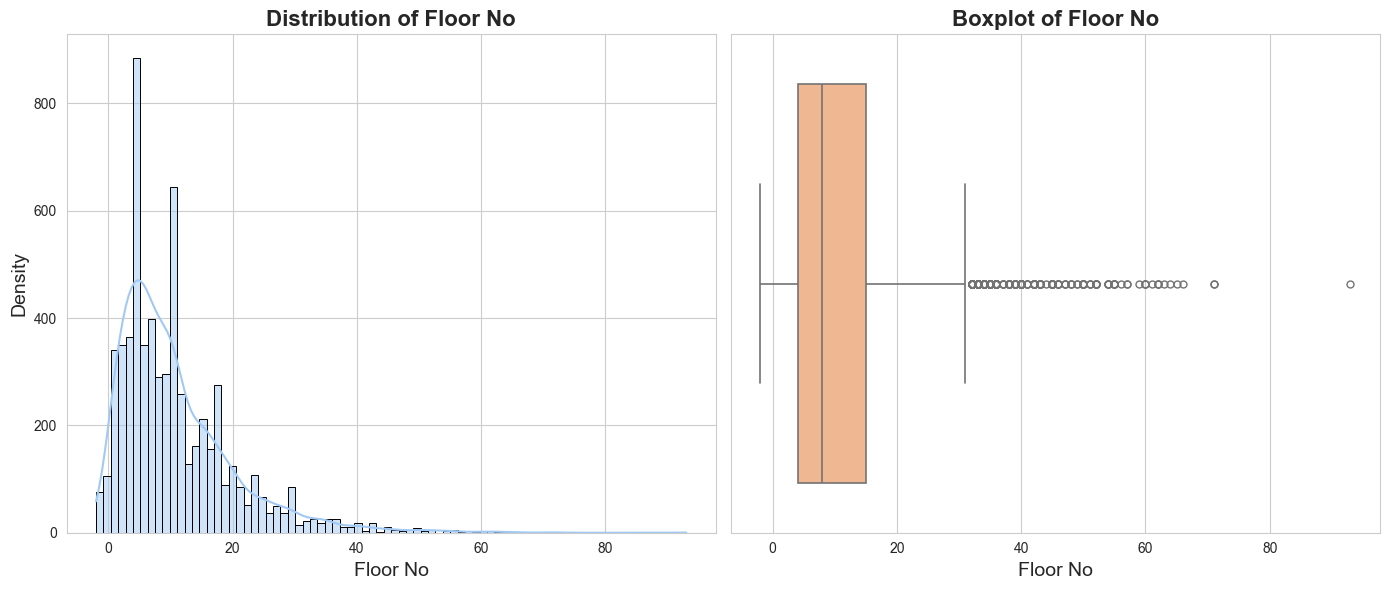

In [9]:
# Statistics of Floor No
print('-----------Statistics of Floor No------------')
print(df['Floor No'].describe())
print()

# Distribution and Box plot of Floor No
plot_distribution_and_boxplot(df, 'Floor No')

In [10]:
# Permanently drop properties having Floor No greater than 75

# Get IDs
idx = df[df['Floor No'] > 75].index

# Drop
df.drop(index=idx, inplace=True)

In [11]:
# Updated shape
df.shape

(6280, 121)

In [12]:
# Initialize 'Floor Level' feature in df with null values
df['Floor Level'] = np.nan

In [13]:
def categorize_floor_number(row: pd.Series) -> str:
    ''' 
    Function to categorize Floor No of property

    Args:
        row: Property in Series form
    '''

    floor_number = row['Floor No']

    if floor_number < 5:
        floor_level = 'Low rise (< 5)'
    elif floor_number >= 5 and floor_number <= 10:
        floor_level = 'Mid rise (5 to 10)'
    else:
        floor_level = 'High rise (> 10)'

    return floor_level


In [14]:
# Categorize properties Floor No
df['Floor Level'] = df.apply(categorize_floor_number, axis=1)

-----------------

Assign Balconies value to '3+' if balconies is greater then 3:

In [16]:
# Get IDs of properties where Balconies is greater than 3
idx = df[df['Balconies'] > 3].index

# Replace Balconies value
df.loc[idx, 'Balconies'] = '3+'

In [17]:
# Convert the column to string (object) dtype
df['Balconies'] = df['Balconies'].astype(str)

In [18]:
# Sample
df.sample(3)

,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Locality,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Power Back Up,Lift,Rain Water Harvesting,Club House,Swimming Pool,Gymnasium,Park,Parking,Security,Water Storage,Private Terrace/Garden,Vaastu Compliant,Service/Goods Lift,Air Conditioned,Visitor Parking,Intercom Facility,Maintenance Staff,Waste Disposal,Laundry Service,Internet/Wi-Fi Connectivity,DTH Television Facility,RO Water System,Banquet Hall,Bar/Lounge,Cafeteria/Food Court,Conference Room,Piped Gas,Jogging and Strolling Track,Outdoor Tennis Courts,Mansion,Downtown,Skyline View,Wrap Around Balcony,Island Kitchen Layout,Full Glass Wall,House help accommodation,Concierge Services,Garden View,Marble flooring,Well Furnished,Modular Kitchen,Helipad,Private pool,Private Jaccuzi,Mini Cinema Theatre,Golf Course,Infinity Swimming Pool,Pool with temperature control,Sea facing,Skydeck,Earth quake resistant,Theme based Architectures,Health club with Steam / Jaccuzi,Large Clubhouse,Large Open space,Fingerprint Access,Grand Entrance lobby,Private Garage,Fireplace,Wine Cellar,Sky Villa,Water Front,Hilltop,Smart Home,Barbeque space,Kids play area,Library,Puja Room,Study,House Help Room,Store Room,Aerobics Room,Canopy Walk,Coffee Lounge & Restaurants,Dance Studio,Event Space & Amphitheatre,Flower Gardens,Guest Accommodation,Indoor Squash & Badminton Courts,Kids Play Area,Kids Play Pool With Water Slides,Library And Business Centre,Meditation Area,Multipurpose Courts,Recreational Pool,Rentable CommuniPfty Space,Retail Boulevard (Retail Shops),Cycling & Jogging Track,Fire Fighting Equipment,Aesthetically designed landscape garden,latitude,longitude,geocoded_address,Area,Price_bin,Floor Level
258,Ready to Move,Immediately,14.0,N,Paradigm Realty,0.85,Not Available,515.0,Paradigm Antalya,16505.0,436.0,Oshiwara,Sq-ft,Unfurnished,1.0,East,Resale,Apartment,Mumbai,1,Owner,22.0,N,Sq-ft,New construction,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.150244,72.834229,"Oshiwara, K/W Ward, Zone 3, Mumbai Suburban, M...",Oshiwara,Medium,High rise (> 10)
4420,Ready to Move,Immediately,7.0,N,Unknown,3.75,"Hospitals, malls, market",1000.0,Raheja Complex,37500.0,750.0,Malad East,Sq-ft,Semi-Furnished,2.0,East,Resale,Apartment,Mumbai,2,Agent,7.0,Y,Sq-ft,15 to 20 years,2.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.186022,72.856318,"Malad East, P/N Ward, Zone 4, Mumbai Suburban,...",Malad East,Very High,Mid rise (5 to 10)
4056,Ready to Move,Immediately,6.0,N,Unknown,3.50,Not Available,950.0,Nathani Residencyq,36842.0,732.0,Agripada,Sq-ft,Unfurnished,2.0,West,Resale,Apartment,Mumbai,2,Agent,21.0,Y,Sq-ft,Less than 5 years,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,18.975040,72.825056,"Agripada, E Ward, Zone 1, Mumbai City, Maharas...",Agripada,Very High,Mid rise (5 to 10)


In [ ]:
# Export the dataframe to a csv file
df.to_csv('Output Files//stage_5a_property_data.csv', index=False)